# Moneyball - Baseball Dataset

URL: http://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

## Content

1) [Data preprocessing](#dataproc)

2) [Model training and evaluation](#train) 
    
2.a) [Linear regression](#linear)

2.b) [Lasso Regression](#lasso)

2.c) [Random Forest](#rf)

2.d) [kNN](#knn)

---



In [2]:
# Basic imports
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# models for linear regression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

# models for Lasso regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Imports for RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# statistic tools
from sklearn import metrics
from statistics import stdev

# data processing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [20]:
input_file = 'Metro_Interstate_Traffic_Volume.csv'
df_raw = pd.read_csv(input_file,  sep = ',', header = 0)
df_raw

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


In [21]:
col_dict = {'holiday':  'Runs Scored', 
            'temp':  'Runs Allowed',
            'rain_1h':  'Run differential (actually difference)',
            'snow_1h':  'Wins',
            'clouds_all':  'On-Base Percentage',
            'weather_main':  'Slugging Percentage',
            'weather_description':  'Batting Average',
            'date_time': 'playoffs reached (binary)',
            'traffic_volume': 'season rank',
            'year': 'playoff rank',
            'month':  'Games Played',
            'day':  'Opponent On-Base Percentage',
            'hour':  'Opponent Slugging Percentage',
            'coeff':  'Opponent Slugging Percentage'
           }

In [22]:
import math
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m, X_train, X_valid, y_train, y_valid, score=''):
    res = {
        'RMS(train)': rmse(m.predict(X_train), y_train),
        'RMS(test)': rmse(m.predict(X_valid), y_valid)}
    if score=='neg_mean_squared_error':
        r2tr = np.sqrt(-m.score(X_train, y_train))
        r2te = np.sqrt(-m.score(X_valid, y_valid))
    elif score=='pos_mean_squared_error':
        r2tr = np.sqrt(m.score(X_train, y_train))
        r2te = np.sqrt(m.score(X_valid, y_valid))
    else:
        r2tr = m.score(X_train, y_train)
        r2te = m.score(X_valid, y_valid)
    res['R2(train)'] = r2tr
    res['R2(test)'] = r2te
    #if hasattr(m, 'oob_score_'): res['oob_score_'] = m.oob_score_
    display(res)
    return res

# Feature importance
from prettytable import PrettyTable as PT # pip install PTable
def print_RF_featureImportance(rf, X):
    table = PT()
    table.field_names = ['Feature', 'Score', 'Comment']
    sum = 0
    for name, score in zip(X.columns.values, rf.feature_importances_):
        print(f"{name}: {score:.5f}\t\t... {col_dict[name]}")
        table.add_row([name, round(score, ndigits=4), col_dict[name]])
        sum += score
    print(table)
    print(f"sum = {sum}")

def print_GridSearchResult(grid):
    print(grid.best_params_)
    print(grid.best_estimator_)

# Preprocessing

## convert the date_time in 4 different coloums 

In [23]:
df_raw["date_time"] = pd.to_datetime(df_raw.date_time)
df_raw["hour"] = df_raw.date_time.dt.hour
df_raw["day"] = df_raw.date_time.dt.day
df_raw["month"] = df_raw.date_time.dt.month
df_raw["year"] = df_raw.date_time.dt.year

df_raw = df_raw.drop("date_time", axis=1)

df_raw

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,hour,day,month,year
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,9,2,10,2012
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516,10,2,10,2012
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,11,2,10,2012
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,12,2,10,2012
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918,13,2,10,2012
...,...,...,...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,3543,19,30,9,2018
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2781,20,30,9,2018
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2159,21,30,9,2018
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,1450,22,30,9,2018


In [24]:
weather_cond = []
weather_des = []

weather_cond = pd.unique(df_raw.weather_main)
weather_des = pd.unique(df_raw.weather_description)
df_raw.holiday[df_raw.holiday == "None"] = 0
df_raw.holiday[df_raw.holiday != 0] = 1

df_raw.temp[df_raw.temp < 100] = np.mean(df_raw.temp)
df_raw.rain_1h[df_raw.rain_1h > 100] = 0

for i in range(len(weather_cond)):
    df_raw.weather_main[df_raw.weather_main == weather_cond[i]] = i
    
for i in range(len(weather_des)):
    df_raw.weather_description[df_raw.weather_description == weather_des[i]] = i

/home/alexander/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/alexander/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/alexander/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/alexander/.local/lib/python3

In [25]:
df_raw

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,hour,day,month,year
0,0,288.28,0.0,0.0,40,0,0,5545,9,2,10,2012
1,0,289.36,0.0,0.0,75,0,1,4516,10,2,10,2012
2,0,289.58,0.0,0.0,90,0,2,4767,11,2,10,2012
3,0,290.13,0.0,0.0,90,0,2,5026,12,2,10,2012
4,0,291.14,0.0,0.0,75,0,1,4918,13,2,10,2012
...,...,...,...,...,...,...,...,...,...,...,...,...
48199,0,283.45,0.0,0.0,75,0,1,3543,19,30,9,2018
48200,0,282.76,0.0,0.0,90,0,2,2781,20,30,9,2018
48201,0,282.73,0.0,0.0,90,7,14,2159,21,30,9,2018
48202,0,282.09,0.0,0.0,90,0,2,1450,22,30,9,2018


## prepare the sclaed dataset 

In [26]:
df_raw_scale = df_raw
min_max_scaler = preprocessing.MinMaxScaler()

df_raw_scale[["temp", "rain_1h","snow_1h","traffic_volume","clouds_all","weather_main","weather_description"]] = min_max_scaler.fit_transform(df_raw[["temp", "rain_1h","snow_1h","traffic_volume","clouds_all","weather_main","weather_description"]])
df_raw_scale["coeff"] = df_raw_scale.clouds_all + df_raw_scale.weather_main + df_raw_scale.weather_description

drop_coll = ["clouds_all","weather_main","weather_description"]
df_raw_scale = df_raw_scale.drop(drop_coll, axis=1)

In [27]:
df_raw

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,hour,day,month,year,coeff
0,0,0.673215,0.0,0.0,0.40,0.0,0.000000,0.761676,9,2,10,2012,0.400000
1,0,0.689412,0.0,0.0,0.75,0.0,0.027027,0.620330,10,2,10,2012,0.777027
2,0,0.692711,0.0,0.0,0.90,0.0,0.054054,0.654808,11,2,10,2012,0.954054
3,0,0.700960,0.0,0.0,0.90,0.0,0.054054,0.690385,12,2,10,2012,0.954054
4,0,0.716107,0.0,0.0,0.75,0.0,0.027027,0.675549,13,2,10,2012,0.777027
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48199,0,0.600780,0.0,0.0,0.75,0.0,0.027027,0.486676,19,30,9,2018,0.777027
48200,0,0.590432,0.0,0.0,0.90,0.0,0.054054,0.382005,20,30,9,2018,0.954054
48201,0,0.589982,0.0,0.0,0.90,0.7,0.378378,0.296566,21,30,9,2018,1.978378
48202,0,0.580384,0.0,0.0,0.90,0.0,0.054054,0.199176,22,30,9,2018,0.954054


## prepare the rushhour dataset 

In [11]:
#df_raw_rush = df_raw
#df_raw_rush = df_raw.hour(0, axis=0)


#df_raw_rush

# Preprocessing LinReg

In [ ]:
#df_raw = df_raw_scale
sns_plot = sns.lmplot("temp","traffic_volume",df_raw)
ax = plt.gca()
ax.set_title("temp vs trafic_volume")
#sns_plot.savefig("analysis/temp vs trafic_volume")

sns.lmplot("rain_1h","traffic_volume",df_raw)
ax = plt.gca()
ax.set_title("rain_1h vs trafic_volume")
#sns_plot.savefig("analysis/rain_1h vs trafic_volume")

sns.lmplot("snow_1h","traffic_volume",df_raw)
ax = plt.gca()
ax.set_title("snow_1h vs trafic_volume")
#sns_plot.savefig("analysis/snow_1h vs trafic_volume")

df_lin = df_raw

# Preprocessing for random forest

In [ ]:
# Split into train and test
def split_simple(df, n): 
    '''n... number to split at'''
    return df[:n].copy(), df[n:].copy()

# Preprocessing for kNN

In [ ]:
from sklearn.impute import SimpleImputer

df_knn = df_raw

from sklearn.impute import SimpleImputer

---
# 2) Model training and evaluation
---

## a) Linear Regression

In [12]:
#df_lin = df_raw_scale
df_lin = df_raw

In [13]:
Y = df_lin[['traffic_volume']]
X = df_lin[['holiday','temp','rain_1h','snow_1h','coeff','hour','day','month','year']]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)

In [14]:
linreg = LinearRegression(normalize = True)
linreg.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [15]:
linreg.coef_
score = linreg.score(X_test,Y_test)
print("Linear regression model score: ",score)
Y_lin_pred = linreg.predict(X_test)

Linear regression model score:  0.13765649572958494


In [16]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_lin_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_lin_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_lin_pred)))

Mean Absolute Error: 0.22368996271458313
Mean Squared Error: 0.0640393976114442
Root Mean Squared Error: 0.2530600672003471


Text(0.5, 1.0, 'traindata vs linear_regression')

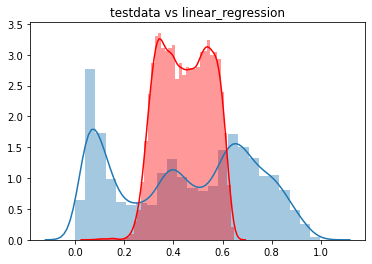

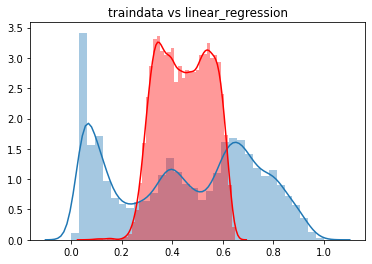

In [45]:
sns.distplot(Y_test)
sns.distplot(Y_lin_pred, color="red")
ax = plt.gca()
ax.set_title("testdata vs linear_regression")

plt.figure()
sns.distplot(Y_train)
sns.distplot(Y_lin_pred, color="red")
ax = plt.gca()
ax.set_title("traindata vs linear_regression")

# b) Lasso Regression

In [29]:
lasso = Lasso(normalize = True)
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,2,5,10,20,30,35,40,45,50,55,100]}
lasso_regressor = GridSearchCV(lasso,parameters,scoring = 'neg_mean_squared_error',cv = 5)

In [30]:
lasso_regressor.fit(X_train,Y_train)
print("Lasso regression model score: ", lasso_regressor.score(X_test, Y_test))
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

Lasso regression model score:  -0.06403942680143088
{'alpha': 1e-08}
-0.06462087646078382


In [31]:
Y_lasso_pred = lasso_regressor.predict(X_test)

In [32]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_lasso_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_lasso_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_lasso_pred)))

Mean Absolute Error: 0.22369029113670522
Mean Squared Error: 0.06403942680143088
Root Mean Squared Error: 0.2530601248743683


Text(0.5, 1.0, 'traindata vs lasso_regression')

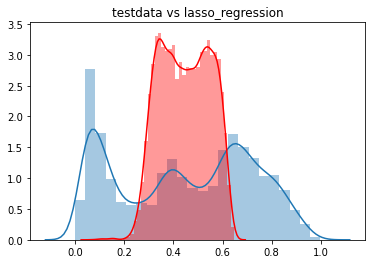

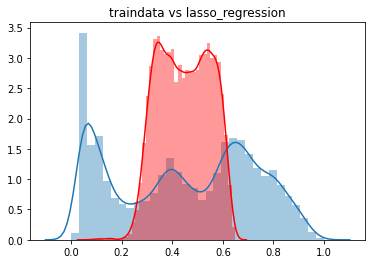

In [46]:
sns.distplot(Y_test)
sns.distplot(Y_lasso_pred, color="red")
ax = plt.gca()
ax.set_title("testdata vs lasso_regression")

plt.figure()
sns.distplot(Y_train)
sns.distplot(Y_lasso_pred, color="red")
ax = plt.gca()
ax.set_title("traindata vs lasso_regression")

# c) kNN

In [47]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from math import sqrt

In [48]:
rmse_val_knn = [] # to store rmse values for different k
for k in range(25):
    k = k + 1
    model = neighbors.KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    error = sqrt(mean_squared_error(Y_test, pred))
    rmse_val_knn.append(error)
    print("RMSE for k={}: {}".format(k, error))
    print("R^2 for k={}: {}\n".format(k, model.score(X_test, Y_test)))

RMSE for k=1: 0.11796703202539953
R^2 for k=1: 0.8126065683827894

RMSE for k=2: 0.09609115330522948
R^2 for k=2: 0.8756631472822134

RMSE for k=3: 0.09401937639963644
R^2 for k=3: 0.8809668871829338

RMSE for k=4: 0.09482550563431513
R^2 for k=4: 0.8789169386907818

RMSE for k=5: 0.09743144886544595
R^2 for k=5: 0.8721704147262039

RMSE for k=6: 0.09967087955730727
R^2 for k=6: 0.8662266386579021

RMSE for k=7: 0.10222945399674667
R^2 for k=7: 0.859270501260321

RMSE for k=8: 0.1043717105844872
R^2 for k=8: 0.8533106240726758

RMSE for k=9: 0.10632749856527106
R^2 for k=9: 0.8477615855904126

RMSE for k=10: 0.10801413681149331
R^2 for k=10: 0.8428934625945873

RMSE for k=11: 0.10959388629485002
R^2 for k=11: 0.8382643666331712

RMSE for k=12: 0.11089809588295399
R^2 for k=12: 0.8343920287168741

RMSE for k=13: 0.11193567223525833
R^2 for k=13: 0.8312786344053306

RMSE for k=14: 0.11309685327370084
R^2 for k=14: 0.8277599664337563

RMSE for k=15: 0.11395684441498356
R^2 for k=15: 0.825

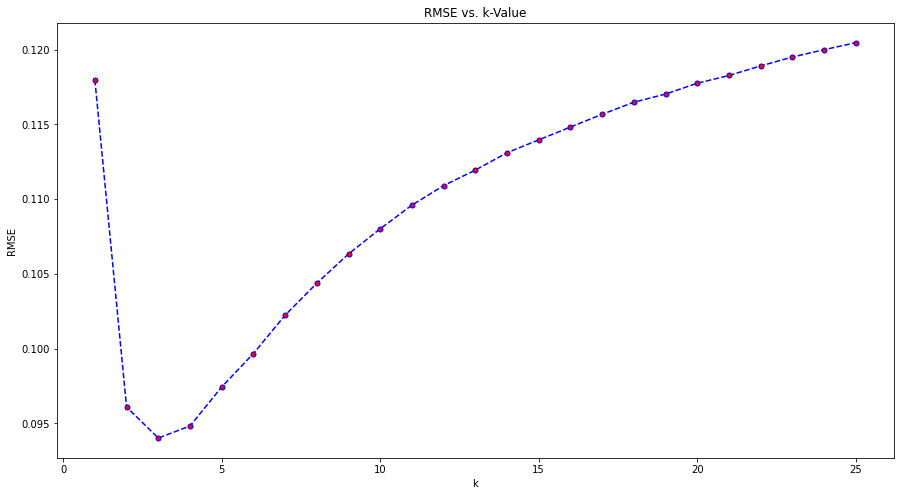

In [51]:
plt.figure(figsize=(15,8))
plt.plot(range(1,26), rmse_val_knn, color='blue', linestyle='dashed', marker='o',
        markerfacecolor='red', markersize=5)
plt.title('RMSE vs. k-Value')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.savefig("analysis/RMSE vs k-Value")

## Optimizing kNN-search for optimal k-Value via Gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': range(1, 25)}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=10)
model.fit(X_train, Y_train)
print("Best k-Value is: ", model.best_params_['n_neighbors'])

In [ ]:
model_cv = neighbors.KNeighborsRegressor(n_neighbors=model.best_params_['n_neighbors'])
model_cv.fit(X_train, Y_train)
pred_cv = model.predict(X_test)
sns.distplot(Y_test)
sns.distplot(pred_cv, color='red')

print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, pred_cv))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, pred_cv))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, pred_cv)))

In [ ]:
sns.distplot(Y_test-pred_cv)

# d) Random Forest

In [52]:
# Imports for RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from IPython.display import display

In [53]:
df_rf = df_raw_scale
# Split for random forest
rnd_state = 42
ratio = 0.2 # test/num_samples
#####
num_instances, _ = df_rf.shape
print(f"From {num_instances} using {num_instances*ratio:.0f} for testing and {num_instances*(1-ratio):.0f} for training. Ratio = {ratio*100:.2f}%")
X, Y = (df_rf.drop(['traffic_volume'], axis=1), df_rf.traffic_volume)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = ratio, random_state = rnd_state)
display(X_test)

From 48204 using 9641 for testing and 38563 for training. Ratio = 20.00%


,holiday,temp,rain_1h,snow_1h,hour,day,month,year,coeff
35748,0,0.691362,0.0,0.0,7,28,7,2017,0.853243
147,0,0.539292,0.0,0.0,21,8,10,2012,0.191081
24362,0,0.719856,0.0,0.0,0,22,6,2016,0.360000
35495,0,0.759298,0.0,0.0,22,19,7,2017,2.356757
11010,0,0.379424,0.0,0.0,9,27,12,2013,1.229189
...,...,...,...,...,...,...,...,...,...
6401,0,0.659718,0.0,0.0,22,25,5,2013,2.032432
34004,0,0.646221,0.0,0.0,9,25,5,2017,0.191081
46086,0,0.771296,0.0,0.0,22,22,7,2018,0.308108
42579,0,0.486953,0.0,0.0,22,23,3,2018,0.954054


In [54]:
before = 0

In [56]:
# Simple training of RFRegressor
n_cores = 4
rf_W = RandomForestRegressor(n_jobs=n_cores)
# The following code is supposed to fail due to string values in the input data
rf_W.fit(X_train, Y_train)
print("Before:")
display(before)#
print("Now:")
before = print_score(rf_W, X_train, X_test, Y_train, Y_test)

Before:


{'RMS(train)': 0.04072318045340647,
 'RMS(test)': 0.10963725546219161,
 'R2(train)': 0.9777263399253807,
 'R2(test)': 0.8388627911412834}

Now:


{'RMS(train)': 0.041019187930240876,
 'RMS(test)': 0.10944999227527687,
 'R2(train)': 0.9774013588229062,
 'R2(test)': 0.8394127738501321}

In [57]:
print_RF_featureImportance(rf_W, X_train)

holiday: 0.00001		... Runs Scored
temp: 0.07968		... Runs Allowed
rain_1h: 0.00644		... Run differential (actually difference)
snow_1h: 0.00003		... Wins
hour: 0.78133		... Opponent Slugging Percentage
day: 0.05313		... Opponent On-Base Percentage
month: 0.02527		... Games Played
year: 0.02304		... playoff rank
coeff: 0.03106		... Opponent Slugging Percentage
+---------+--------+----------------------------------------+
| Feature | Score  |                Comment                 |
+---------+--------+----------------------------------------+
| holiday |  0.0   |              Runs Scored               |
|   temp  | 0.0797 |              Runs Allowed              |
| rain_1h | 0.0064 | Run differential (actually difference) |
| snow_1h |  0.0   |                  Wins                  |
|   hour  | 0.7813 |      Opponent Slugging Percentage      |
|   day   | 0.0531 |      Opponent On-Base Percentage       |
|  month  | 0.0253 |              Games Played              |
|   year  | 0.023 

In [58]:
rf_W_prediction = rf_W.predict(X_test)

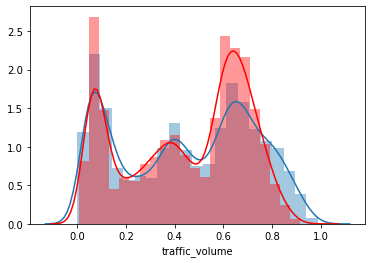

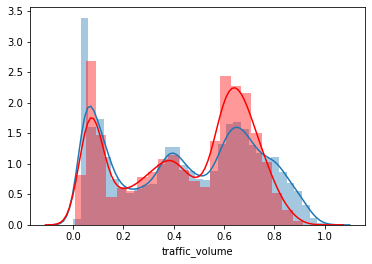

In [62]:
sns.distplot(Y_test)
sns.distplot(rf_W_prediction, color="red")

plt.figure()
sns.distplot(Y_train)
sns.distplot(rf_W_prediction, color="red")

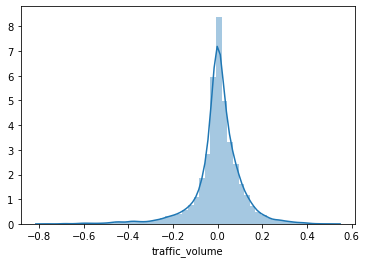

In [60]:
sns.distplot(Y_test-rf_W_prediction)

In [61]:
n_cores = 4
number_of_trees = 100 # default = 100
rf = RandomForestRegressor(n_jobs=n_cores, n_estimators=number_of_trees, bootstrap=True) #, verbose=1)

rf.fit(X_train, Y_train)
print("Before:")
display(before)#
print("Now:")
before = print_score(rf, X_train, X_test, Y_train, Y_test)
print()
print("Feature importance")
print_RF_featureImportance(rf, X_train)
rf_RD = rf

Before:


{'RMS(train)': 0.041019187930240876,
 'RMS(test)': 0.10944999227527687,
 'R2(train)': 0.9774013588229062,
 'R2(test)': 0.8394127738501321}

Now:


{'RMS(train)': 0.04074755337128946,
 'RMS(test)': 0.10935715912728956,
 'R2(train)': 0.9776996702724896,
 'R2(test)': 0.8396850716397221}


Feature importance
holiday: 0.00001		... Runs Scored
temp: 0.07994		... Runs Allowed
rain_1h: 0.00644		... Run differential (actually difference)
snow_1h: 0.00003		... Wins
hour: 0.78085		... Opponent Slugging Percentage
day: 0.05308		... Opponent On-Base Percentage
month: 0.02540		... Games Played
year: 0.02298		... playoff rank
coeff: 0.03126		... Opponent Slugging Percentage
+---------+--------+----------------------------------------+
| Feature | Score  |                Comment                 |
+---------+--------+----------------------------------------+
| holiday |  0.0   |              Runs Scored               |
|   temp  | 0.0799 |              Runs Allowed              |
| rain_1h | 0.0064 | Run differential (actually difference) |
| snow_1h |  0.0   |                  Wins                  |
|   hour  | 0.7809 |      Opponent Slugging Percentage      |
|   day   | 0.0531 |      Opponent On-Base Percentage       |
|  month  | 0.0254 |              Games Played              

In [ ]:
rfRD_prediction = rf_RD.predict(X_test)

In [ ]:
sns.distplot(Y_test)
sns.distplot(rfRD_prediction, color="red")

In [ ]:
sns.distplot(Y_test-rfRD_prediction)

# Optimize Hyperparameters via GridSearch

because we lazy bois

## Notes on the RandomForestRegressor from scikit-learn
-----
The default values for the parameters controlling the size of the trees
(e.g. ``max_depth``, ``min_samples_leaf``, etc.) lead to fully grown and
unpruned trees which can potentially be very large on some data sets. To
reduce memory consumption, the complexity and size of the trees should be
controlled by setting those parameter values.

## Number of variables/features per tree --> 'max_features'

A good starting point is/might be: *the square root of the number of features presented to the tree*. Then, test some values below and above that starting point.

## Number of trees in the forest --> 'n_estimators'

The more the merrier

In [ ]:
from numpy import sqrt
num_features = X.shape[1]
print(num_features)
sqrt_num_features = round(sqrt(num_features), 0)
sqrt_num_features

In [ ]:
from sklearn.model_selection import GridSearchCV
n_cores = 4
# but since we dont have that many features...we are just gonna brute force it :D
param_grid = [
    {
        'n_estimators': [3, 10, 30, 40, 100], 'max_features': [i for i in range(1,num_features+1)]
    }
#,{'bootstrap': [False], 'n_estimators': [3, 30, 100, 1000], 'max_features': [2, 3, 4]},
]
k = 2
forest_reg = RandomForestRegressor(n_jobs=n_cores)
grid_search = GridSearchCV(forest_reg, param_grid, n_jobs=n_cores , cv=k, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, Y_train)


In [ ]:
print_GridSearchResult(grid_search)
#grid_search.scorer_()
scores = grid_search.score(X_test, Y_test)
print_score(grid_search, X_train, X_test, Y_train, Y_test)